In [2]:
# ===========================
# RUTAS (las tuyas en Drive)
# ===========================
from google.colab import drive
drive.mount('/content/drive/', force_remount=False)

XML_EQUIPO    = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Equipo/UnionEzpeletaEq - asXML.xml"
XML_JUGADORES = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Jugadores/Union Ezpeleta - XML NacSport.xml"
MATRIX_PATH   = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Jugadores/Union Ezpeleta - Matrix.xlsx"  # o .csv si corresponde

# ===========================
# IMPORTS
# ===========================
import re, unicodedata, math, os, pandas as pd, xml.etree.ElementTree as ET

def ntext(s):
    if s is None: return ""
    s = str(s)
    s = unicodedata.normalize("NFD", s)
    s = "".join(ch for ch in s if unicodedata.category(ch) != "Mn")
    return s.strip()
def nlower(s): return ntext(s).lower()

# ===========================
# 1) POSESIÓN (XML EQUIPO)
# ===========================
def parse_possession_from_equipo(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    t_ferro = t_rival = 0.0
    for inst in root.findall(".//instance"):
        code  = nlower(inst.findtext("code"))
        try:
            st = float(inst.findtext("start") or "0")
            en = float(inst.findtext("end") or "0")
        except:
            continue
        dur = max(0.0, en - st)
        if code == "tiempo posecion ferro":
            t_ferro += dur
        elif code == "tiempo posecion rival":
            t_rival += dur
    tot = t_ferro + t_rival
    if tot <= 0: return 0.0, 0.0
    return round(100*t_ferro/tot,1), round(100*t_rival/tot,1)

# ============================================
# 2) MATRIX: sumar por variables (fila=jugador)
# ============================================
def load_matrix(path):
    if path.lower().endswith(".xlsx"):
        df = pd.read_excel(path, header=0)  # fila 1 = nombres de variables
    elif path.lower().endswith(".csv"):
        try:
            df = pd.read_csv(path, header=0)
        except Exception:
            df = pd.read_csv(path, header=0, sep=";")
    else:
        raise ValueError("Formato no soportado para MATRIX (usa .xlsx o .csv)")

    # Primera columna = jugadores / Categoria - Equipo Rival
    player_col = df.columns[0]

    # Convertir a numérico el resto
    for c in df.columns[1:]:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

    # Mapa de encabezados normalizados (sin tildes, lower)
    header_map = {c: nlower(c) for c in df.columns}
    return df, player_col, header_map

def sum_cols(df, who_mask, header_map, col_regex):
    """
    Suma las columnas cuyos nombres (normalizados) matchean col_regex (regex),
    filtrando por who_mask (FERRO o RIVAL). Ignora filas NaN/vacías de la columna A.
    """
    cols = [c for c in df.columns[1:] if re.search(col_regex, header_map[c], re.I)]
    if not cols:
        return 0
    return int(df.loc[who_mask, cols].sum(numeric_only=True).sum())

def compute_from_matrix(path):
    df, player_col, header_map = load_matrix(path)

    # ---- Filas válidas (evita que NaN/ vacío en col A se cuente) ----
    who_raw = df[player_col]
    is_valid = who_raw.notna() & (who_raw.astype(str).str.strip() != "")

    # Normalizado para comparar el rival
    who = who_raw.fillna("").astype(str).map(nlower)

    # ---- Máscaras de equipo ----
    is_rival = is_valid & (who == "categoria - equipo rival")
    is_mine  = is_valid & ~is_rival

    # ---- PATRONES EXACTOS ----
    pases_tot_re = r"^pase.*frontal|^pase.*lateral"
    pases_ok_re  = r"^pase.*completado"
    tiros_re     = r"\btiro hecho\b"
    taro_re      = r"\btiro atajado\b"
    recup_re     = r"^recuperacion\b"
    duelo_g_re   = r"\brecuperacion x duelo\b"
    duelo_p_re   = r"\bperdida x duelo\b"
    corners_re   = r"\bcorner en corto\b|\bcorner al area\b|\bcorner 2do palo\b"
    faltas_re    = r"\bfaltas recibidas\b"
    goles_re     = r"^gol\b"
    asis_re      = r"\basistencia\b"
    pclave_re    = r"\bpase clave\b"

    # ---- FERRO ----
    pases_tot_m = sum_cols(df, is_mine,  header_map, pases_tot_re)
    pases_ok_m  = sum_cols(df, is_mine,  header_map, pases_ok_re)
    tiros_m     = sum_cols(df, is_mine,  header_map, tiros_re)
    taro_m      = sum_cols(df, is_mine,  header_map, taro_re)
    recup_m     = sum_cols(df, is_mine,  header_map, recup_re)
    duelo_g_m   = sum_cols(df, is_mine,  header_map, duelo_g_re)
    duelo_p_m   = sum_cols(df, is_mine,  header_map, duelo_p_re)
    corners_m   = sum_cols(df, is_mine,  header_map, corners_re)
    faltas_m    = sum_cols(df, is_mine,  header_map, faltas_re)
    goles_m     = sum_cols(df, is_mine,  header_map, goles_re)
    asis_m      = sum_cols(df, is_mine,  header_map, asis_re)
    pclave_m    = sum_cols(df, is_mine,  header_map, pclave_re)

    # ---- RIVAL ----
    pases_tot_r = sum_cols(df, is_rival, header_map, pases_tot_re)
    pases_ok_r  = sum_cols(df, is_rival, header_map, pases_ok_re)
    tiros_r     = sum_cols(df, is_rival, header_map, tiros_re)
    taro_r      = sum_cols(df, is_rival, header_map, taro_re)
    recup_r     = sum_cols(df, is_rival, header_map, recup_re)
    duelo_g_r   = sum_cols(df, is_rival, header_map, duelo_g_re)
    duelo_p_r   = sum_cols(df, is_rival, header_map, duelo_p_re)
    corners_r   = sum_cols(df, is_rival, header_map, corners_re)
    faltas_r    = sum_cols(df, is_rival, header_map, faltas_re)
    goles_r     = sum_cols(df, is_rival, header_map, goles_re)
    asis_r      = sum_cols(df, is_rival, header_map, asis_re)
    pclave_r    = sum_cols(df, is_rival, header_map, pclave_re)

    def pct(a,b): return round(100*a/b,1) if b else 0.0
    mx = {
        "FERRO": {
            "Pases totales": pases_tot_m,
            "Pases OK %": pct(pases_ok_m, pases_tot_m),
            "Tiros": tiros_m,
            "Tiros al arco": taro_m,
            "Recuperaciones": recup_m,
            "Duelos Ganados": duelo_g_m,
            "% Duelos Ganados": pct(duelo_g_m, duelo_g_m + duelo_p_m),
            "Corners": corners_m,
            "Faltas": faltas_m,
            "Goles": goles_m,
            "Asistencias": asis_m,
            "Pases Clave": pclave_m,
        },
        "RIVAL": {
            "Pases totales": pases_tot_r,
            "Pases OK %": pct(pases_ok_r, pases_tot_r),
            "Tiros": tiros_r,
            "Tiros al arco": taro_r,
            "Recuperaciones": recup_r,
            "Duelos Ganados": duelo_g_r,
            "% Duelos Ganados": pct(duelo_g_r, duelo_g_r + duelo_p_r),
            "Corners": corners_r,
            "Faltas": faltas_r,
            "Goles": goles_r,
            "Asistencias": asis_r,
            "Pases Clave": pclave_r,
        }
    }
    return mx


# =====================================================
# 3) JUGADORES XML → Último tercio y Pases al área
# =====================================================
def parse_instances_jugadores(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    out = []
    for inst in root.findall(".//instance"):
        code = ntext(inst.findtext("code"))
        labels_lc = [nlower(t.text) for t in inst.findall("./label/text")]
        # coords: tomar el último par como destino
        xs = [int(x.text) for x in inst.findall("./pos_x") if (x.text or "").isdigit()]
        ys = [int(y.text) for y in inst.findall("./pos_y") if (y.text or "").isdigit()]
        x_end, y_end = (xs[-1], ys[-1]) if xs and ys else (None, None)
        out.append({"code": code, "labels_lc": labels_lc, "end_xy": (x_end, y_end)})
    return out

def is_pass_attempt(inst):
    if re.match(r"^\s*pase\b", nlower(inst["code"])): return True
    return any(re.match(r"^\s*pase\b", l) for l in inst["labels_lc"])

def is_rival_code(code):
    return nlower(code).startswith("categoria - equipo rival")

def xy_to_zone(x, y, max_x=19, max_y=34):
    if x is None or y is None: return None
    col = 1 if x <= 6 else (2 if x <= 13 else 3)   # 1..6 | 7..13 | 14..19
    row = 1 if y <= 11 else (2 if y <= 22 else 3)  # 1..11 | 12..22 | 23..34
    return (row-1)*3 + col  # 1..9

def passes_last_third_and_area(jug):
    last_m = last_r = area_m = area_r = 0
    for ev in jug:
        if not is_pass_attempt(ev):
            continue
        x, y = ev["end_xy"]
        z = xy_to_zone(x, y)
        if z is None:
            continue
        if is_rival_code(ev["code"]):
            if z in {1,4,7}: last_r += 1
            if z == 4: area_r += 1
        else:
            if z in {3,6,9}: last_m += 1
            if z == 6: area_m += 1
    return last_m, last_r, area_m, area_r

# ===========================
# PIPELINE Y SALIDA
# ===========================
pos_m, pos_r = parse_possession_from_equipo(XML_EQUIPO)
mx = compute_from_matrix(MATRIX_PATH)
jug = parse_instances_jugadores(XML_JUGADORES)
last_m, last_r, area_m, area_r = passes_last_third_and_area(jug)

print("=== FERRO (Equipo) ===")
print(f"Posesión %: {pos_m}")
print(f"Pases totales: {mx['FERRO']['Pases totales']}")
print(f"Pases OK %: {mx['FERRO']['Pases OK %']}")
print(f"Pases último tercio (Z3/6/9): {last_m}")
print(f"Pases al Área (Z6): {area_m}")
print(f"Tiros: {mx['FERRO']['Tiros']}")
print(f"Tiros al arco: {mx['FERRO']['Tiros al arco']}")
print(f"Recuperaciones: {mx['FERRO']['Recuperaciones']}")
print(f"Duelos Ganados: {mx['FERRO']['Duelos Ganados']}")
print(f"% Duelos Ganados: {mx['FERRO']['% Duelos Ganados']}%")
print(f"Corners: {mx['FERRO']['Corners']}")
print(f"Faltas: {mx['FERRO']['Faltas']}")
print(f"Goles: {mx['FERRO']['Goles']}")
print(f"Asistencias: {mx['FERRO']['Asistencias']}")
print(f"Pases Clave: {mx['FERRO']['Pases Clave']}")

print("\n=== RIVAL ===")
print(f"Posesión %: {pos_r}")
print(f"Pases totales: {mx['RIVAL']['Pases totales']}")
print(f"Pases OK %: {mx['RIVAL']['Pases OK %']}")
print(f"Pases último tercio (Z1/4/7): {last_r}")
print(f"Pases al Área (Z4): {area_r}")
print(f"Tiros: {mx['RIVAL']['Tiros']}")
print(f"Tiros al arco: {mx['RIVAL']['Tiros al arco']}")
print(f"Recuperaciones: {mx['RIVAL']['Recuperaciones']}")
print(f"Duelos Ganados: {mx['RIVAL']['Duelos Ganados']}")
print(f"% Duelos Ganados: {mx['RIVAL']['% Duelos Ganados']}%")
print(f"Corners: {mx['RIVAL']['Corners']}")
print(f"Faltas: {mx['RIVAL']['Faltas']}")
print(f"Goles: {mx['RIVAL']['Goles']}")
print(f"Asistencias: {mx['RIVAL']['Asistencias']}")
print(f"Pases Clave: {mx['RIVAL']['Pases Clave']}")


Mounted at /content/drive/
=== FERRO (Equipo) ===
Posesión %: 56.6
Pases totales: 343
Pases OK %: 28.6
Pases último tercio (Z3/6/9): 51
Pases al Área (Z6): 20
Tiros: 35
Tiros al arco: 17
Recuperaciones: 69
Duelos Ganados: 13
% Duelos Ganados: 48.1%
Corners: 9
Faltas: 2
Goles: 3
Asistencias: 2
Pases Clave: 4

=== RIVAL ===
Posesión %: 43.4
Pases totales: 165
Pases OK %: 22.4
Pases último tercio (Z1/4/7): 21
Pases al Área (Z4): 11
Tiros: 8
Tiros al arco: 5
Recuperaciones: 57
Duelos Ganados: 15
% Duelos Ganados: 68.2%
Corners: 1
Faltas: 3
Goles: 2
Asistencias: 1
Pases Clave: 2


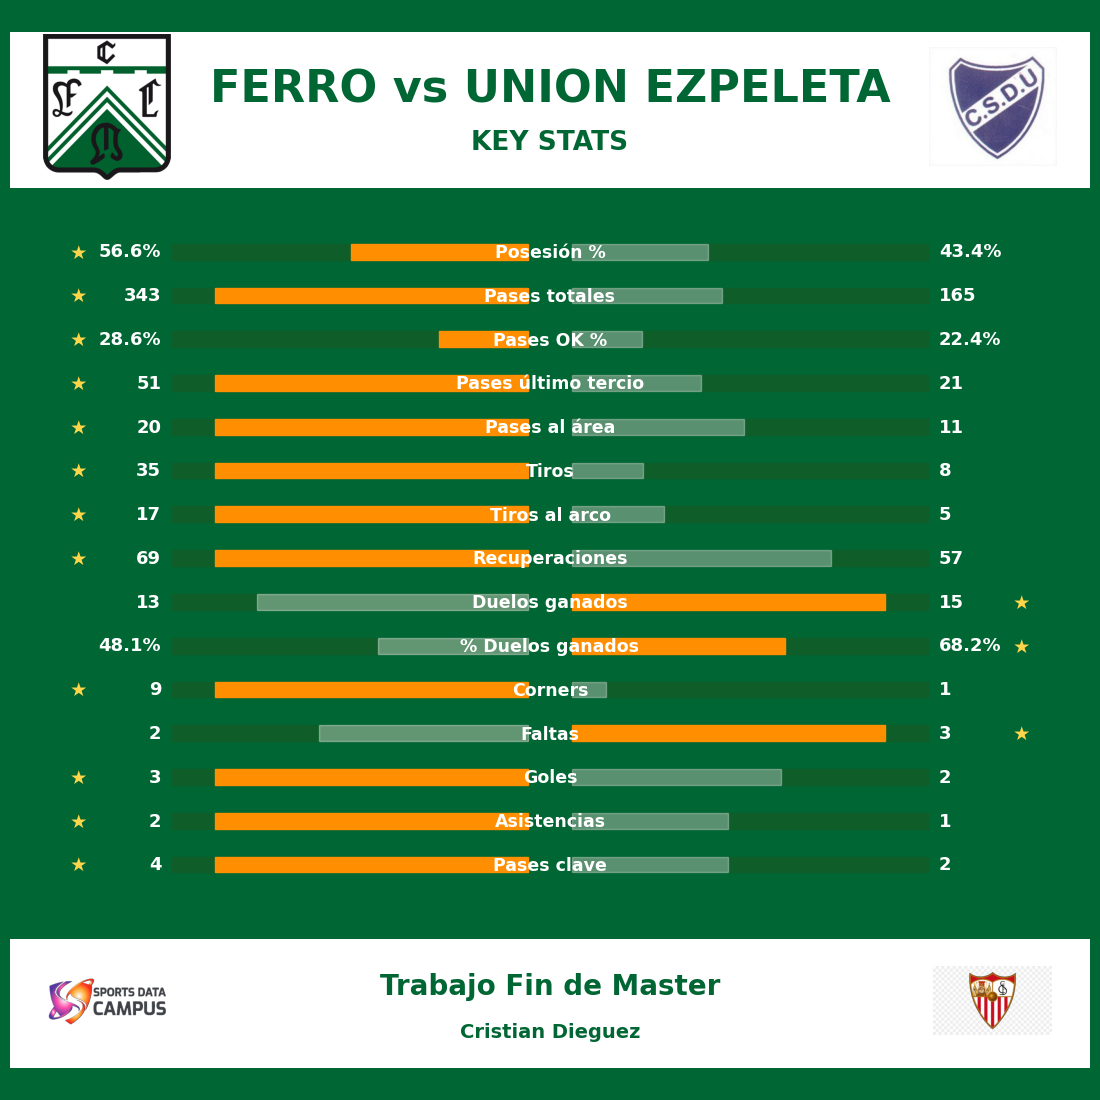

In [19]:
# ===========================
# VISUAL con Banner superior (blanco) + Escudos iguales + Título en verde
# + Banner inferior (blanco) con logos y firma
# Fondo general verde, textos blancos en el cuerpo, ⭐ ganador al costado del rótulo
# ===========================
import os, re, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

# ---- rutas a escudos (superior) ----
LOGO_FERRO_PATH = "/content/drive/MyDrive/Sport Data Campus/TFM/Equipos/ferro.png"
LOGO_RIVAL_PATH = "/content/drive/MyDrive/Sport Data Campus/TFM/Equipos/ezpeleta.png"

# ---- rutas a logos (banner inferior) ----
FOOTER_LOGO_LEFT  = "/content/drive/MyDrive/Sport Data Campus/TFM/Banner/SportData.png"
FOOTER_LOGO_RIGHT = "/content/drive/MyDrive/Sport Data Campus/TFM/Banner/Sevilla.png"

# --- switches / estilo ---
USE_ORANGE_FOR_WIN = True     # barra ganadora en naranja Ferro
RAISE_LABELS       = True     # subir rótulos para evitar solape
BAR_HEIGHT_FACTOR  = 0.36     # altura relativa de barras (0.30–0.42 recomendable)
LABEL_Y_SHIFT_LOW  = 0.60     # altura base del rótulo
LABEL_Y_SHIFT_HIGH = 0.37     # altura cuando se eleva
TRIM_LOGO_BORDERS  = True     # recorta márgenes blancos/transp. para igualar tamaño visual

# --- banner superior (diales rápidos) ---
BANNER_H   = 0.145           # alto del banner superior
LOGO_W     = 0.118           # ancho normalizado de cada escudo dentro del banner
TITLE_FS   = 32              # tamaño de "FERRO vs RIVAL"
SUB_FS     = 19              # tamaño de "KEY STATS"

# --- banner inferior (diales rápidos) ---
FOOTER_H        = 0.120      # alto del banner inferior
FOOTER_LOGO_W   = 0.110      # ancho normalizado de cada logo del footer
FOOTER_TITLE_FS = 20         # "Trabajo Fin de Master"
FOOTER_SUB_FS   = 14         # "Cristian Dieguez"

# Colores
bg_green   = "#006633"   # Ferro
text_w     = "#FFFFFF"
bar_white  = "#FFFFFF"
bar_rival  = "#E6EEF2"
bar_rail   = "#0F5E29"
star_c     = "#FFD54A"
loser_alpha = 0.35
orange_win = "#FF8F00"

# Matplotlib theme
mpl.rcParams.update({
    "savefig.facecolor": bg_green,
    "figure.facecolor":  bg_green,
    "axes.facecolor":    bg_green,
    "text.color":        text_w,
})

def infer_opponent(*paths):
    cand = None
    for p in paths:
        if not p: continue
        base = os.path.basename(p); name = os.path.splitext(base)[0]
        parts = [x.strip() for x in re.split(r"\s*-\s*", name)]
        if parts: cand = parts[0]
        cand = re.sub(r"(?i)categoria\s*\-\s*equipo\s*rival", "", cand or "").strip()
        if cand: break
    cand = re.sub(r"([a-z])([A-Z])", r"\1 \2", cand or "")
    cand = re.sub(r"[_]+", " ", cand).strip()
    return cand if cand else "Rival"

opponent_name = infer_opponent(MATRIX_PATH, XML_JUGADORES)

# ---- datos (desde tu pipeline) ----
FERRO = {
    "Posesión %":           float(pos_m),
    "Pases totales":        int(mx["FERRO"]["Pases totales"]),
    "Pases OK %":           float(mx["FERRO"]["Pases OK %"]),
    "Pases último tercio":  int(last_m),
    "Pases al área":        int(area_m),
    "Tiros":                int(mx["FERRO"]["Tiros"]),
    "Tiros al arco":        int(mx["FERRO"]["Tiros al arco"]),
    "Recuperaciones":       int(mx["FERRO"]["Recuperaciones"]),
    "Duelos ganados":       int(mx["FERRO"]["Duelos Ganados"]),
    "% Duelos ganados":     float(mx["FERRO"]["% Duelos Ganados"]),
    "Corners":              int(mx["FERRO"]["Corners"]),
    "Faltas":               int(mx["FERRO"]["Faltas"]),
    "Goles":                int(mx["FERRO"]["Goles"]),
    "Asistencias":          int(mx["FERRO"]["Asistencias"]),
    "Pases clave":          int(mx["FERRO"]["Pases Clave"]),
}
RIVAL = {
    "Posesión %":           float(pos_r),
    "Pases totales":        int(mx["RIVAL"]["Pases totales"]),
    "Pases OK %":           float(mx["RIVAL"]["Pases OK %"]),
    "Pases último tercio":  int(last_r),
    "Pases al área":        int(area_r),
    "Tiros":                int(mx["RIVAL"]["Tiros"]),
    "Tiros al arco":        int(mx["RIVAL"]["Tiros al arco"]),
    "Recuperaciones":       int(mx["RIVAL"]["Recuperaciones"]),
    "Duelos ganados":       int(mx["RIVAL"]["Duelos Ganados"]),
    "% Duelos ganados":     float(mx["RIVAL"]["% Duelos Ganados"]),
    "Corners":              int(mx["RIVAL"]["Corners"]),
    "Faltas":               int(mx["RIVAL"]["Faltas"]),
    "Goles":                int(mx["RIVAL"]["Goles"]),
    "Asistencias":          int(mx["RIVAL"]["Asistencias"]),
    "Pases clave":          int(mx["RIVAL"]["Pases Clave"]),
}

rows = [
    "Posesión %", "Pases totales", "Pases OK %", "Pases último tercio", "Pases al área",
    "Tiros", "Tiros al arco", "Recuperaciones",
    "Duelos ganados", "% Duelos ganados",
    "Corners", "Faltas", "Goles", "Asistencias", "Pases clave"
]
is_percent = {"Posesión %", "Pases OK %", "% Duelos ganados"}

# ---- utilidades para logos ----
def load_any_image(path):
    im = Image.open(path); im.load()
    if im.mode != "RGBA":
        im = im.convert("RGBA")
    return np.array(im)

def trim_margins(img_rgba, bg_tol=12):
    """Recorta márgenes blancos/transparentes para igualar tamaño visual."""
    h, w, _ = img_rgba.shape
    alpha = img_rgba[:,:,3]
    rgb = img_rgba[:,:,:3].astype(np.int16)
    white_mask = (np.abs(255 - rgb).max(axis=2) <= bg_tol)
    useful = (~white_mask) | (alpha > 0)
    rows = np.where(useful.any(axis=1))[0]
    cols = np.where(useful.any(axis=0))[0]
    if rows.size == 0 or cols.size == 0: return img_rgba
    r0, r1 = rows[0], rows[-1]; c0, c1 = cols[0], cols[-1]
    return img_rgba[r0:r1+1, c0:c1+1, :]

def draw_logo(ax, path, cx, cy, width):
    try:
        img = load_any_image(path)
        if TRIM_LOGO_BORDERS:
            img = trim_margins(img)
    except Exception:
        return
    h, w = img.shape[0], img.shape[1]
    aspect = h / w if w else 1.0
    w_norm = width; h_norm = width * aspect
    ax.imshow(img, extent=[cx - w_norm/2, cx + w_norm/2,
                           cy - h_norm/2, cy + h_norm/2],
              zorder=6)

# ---- lienzo ----
plt.close("all")
# un poquito más alto para alojar ambos banners
fig_h = 0.66*len(rows) + 4.6
fig = plt.figure(figsize=(10.8, fig_h))
ax = fig.add_axes([0,0,1,1]); ax.set_xlim(0,1); ax.set_ylim(0,1); ax.axis("off")

# fondo verde
ax.add_patch(Rectangle((0,0), 1, 1, facecolor=bg_green, edgecolor="none", zorder=-10))

# ---- Banner superior blanco ----
BANNER_Y0 = 1.0 - (BANNER_H + 0.02)   # aire arriba
ax.add_patch(Rectangle((0, BANNER_Y0), 1, BANNER_H,
                       facecolor="white", edgecolor="none", zorder=5))
# Escudos superiores (iguales)
draw_logo(ax, LOGO_FERRO_PATH, 0.09, BANNER_Y0 + BANNER_H*0.52, LOGO_W)
draw_logo(ax, LOGO_RIVAL_PATH, 0.91, BANNER_Y0 + BANNER_H*0.52, LOGO_W)
# Títulos superiores (verde)
ax.text(0.5, BANNER_Y0 + BANNER_H*0.63, f"FERRO vs {opponent_name.upper()}",
        ha="center", va="center", fontsize=TITLE_FS, weight="bold", color=bg_green, zorder=7)
ax.text(0.5, BANNER_Y0 + BANNER_H*0.29, "KEY STATS",
        ha="center", va="center", fontsize=SUB_FS, weight="bold", color=bg_green, zorder=7)

# ---- Banner inferior blanco (firma) ----
FOOTER_Y0 = 0.02                     # aire abajo
ax.add_patch(Rectangle((0, FOOTER_Y0), 1, FOOTER_H,
                       facecolor="white", edgecolor="none", zorder=5))
# Logos inferiores
draw_logo(ax, FOOTER_LOGO_LEFT,  0.09, FOOTER_Y0 + FOOTER_H*0.52, FOOTER_LOGO_W)
draw_logo(ax, FOOTER_LOGO_RIGHT, 0.91, FOOTER_Y0 + FOOTER_H*0.52, FOOTER_LOGO_W)
# Textos inferiores (verde)
ax.text(0.5, FOOTER_Y0 + FOOTER_H*0.63, "Trabajo Fin de Máster",
        ha="center", va="center", fontsize=FOOTER_TITLE_FS, weight="bold", color=bg_green, zorder=7)
ax.text(0.5, FOOTER_Y0 + FOOTER_H*0.28, "Cristian Dieguez",
        ha="center", va="center", fontsize=FOOTER_SUB_FS,   weight="bold", color=bg_green, zorder=7)

# ---- cuerpo (verde) entre ambos banners ----
EXTRA_GAP_BELOW_BANNER = 0.075
top_y    = BANNER_Y0 - EXTRA_GAP_BELOW_BANNER                  # pequeño gap bajo el banner superior
bottom_y = FOOTER_Y0 + FOOTER_H + 0.012       # pequeño gap sobre el banner inferior
available_h = max(0.01, top_y - bottom_y)     # seguridad
row_h = available_h / len(rows)

mid_x, bar_w = 0.5, 0.33
left_star_x, right_star_x = 0.055, 0.945

def draw_row(y, label, lv, rv):
    # rótulo
    label_y = y + row_h*(LABEL_Y_SHIFT_HIGH if RAISE_LABELS else LABEL_Y_SHIFT_LOW)
    ax.text(0.5, label_y, label, ha="center", va="center",
            fontsize=12.5, weight="bold", color=text_w)

    # escala
    maxval = 100.0 if label in is_percent else max(1, lv, rv)

    # carriles
    lane_y = y + row_h*(0.22)
    lane_h = row_h*BAR_HEIGHT_FACTOR
    for x0 in (mid_x - bar_w - 0.02, mid_x + 0.02):
        ax.add_patch(Rectangle((x0, lane_y), bar_w, lane_h,
                               facecolor=bar_rail, edgecolor=bar_rail))

    # ganador y colores
    winner = "FERRO" if lv > rv else ("RIVAL" if rv > lv else "EMPATE")
    ferro_col   = orange_win if (USE_ORANGE_FOR_WIN and winner=="FERRO") else bar_white
    rival_col   = orange_win if (USE_ORANGE_FOR_WIN and winner=="RIVAL") else bar_rival
    ferro_alpha = 1.0 if winner!="RIVAL" else loser_alpha
    rival_alpha = 1.0 if winner!="FERRO" else loser_alpha

    # anchos (acortados desde el centro)
    scale = 0.88
    lw = 0 if maxval==0 else bar_w*(lv/maxval)*scale
    rw = 0 if maxval==0 else bar_w*(rv/maxval)*scale

    # barras
    ax.add_patch(Rectangle((mid_x - 0.02 - lw, lane_y), lw, lane_h,
                           facecolor=ferro_col, edgecolor=ferro_col, alpha=ferro_alpha))
    ax.add_patch(Rectangle((mid_x + 0.02, lane_y), rw, lane_h,
                           facecolor=rival_col, edgecolor=rival_col, alpha=rival_alpha))

    # valores
    ltxt = f"{lv:.1f}%" if label in is_percent else f"{int(lv)}"
    rtxt = f"{rv:.1f}%" if label in is_percent else f"{int(rv)}"
    left_x_txt  = mid_x - bar_w - 0.030
    right_x_txt = mid_x + bar_w + 0.030
    ax.text(left_x_txt,  lane_y + lane_h*0.45, ltxt, ha="right", va="center",
            fontsize=13, weight="bold", color=text_w)
    ax.text(right_x_txt, lane_y + lane_h*0.45, rtxt, ha="left",  va="center",
            fontsize=13, weight="bold", color=text_w)

    # ⭐ al costado del rótulo
    if winner == "FERRO":
        ax.text(left_star_x,  label_y, "★", ha="left",  va="center",
                fontsize=14, color=star_c, weight="bold", clip_on=False)
    elif winner == "RIVAL":
        ax.text(right_star_x, label_y, "★", ha="right", va="center",
                fontsize=14, color=star_c, weight="bold", clip_on=False)

# render
y = top_y
for lab in rows:
    draw_row(y, lab, FERRO.get(lab,0), RIVAL.get(lab,0))
    y -= row_h

out_path = "/content/key_stats_ferro_vs_{}_banner.png".format(opponent_name.replace(" ","_"))
plt.savefig(out_path, dpi=320, bbox_inches="tight", pad_inches=0.05)
plt.show()


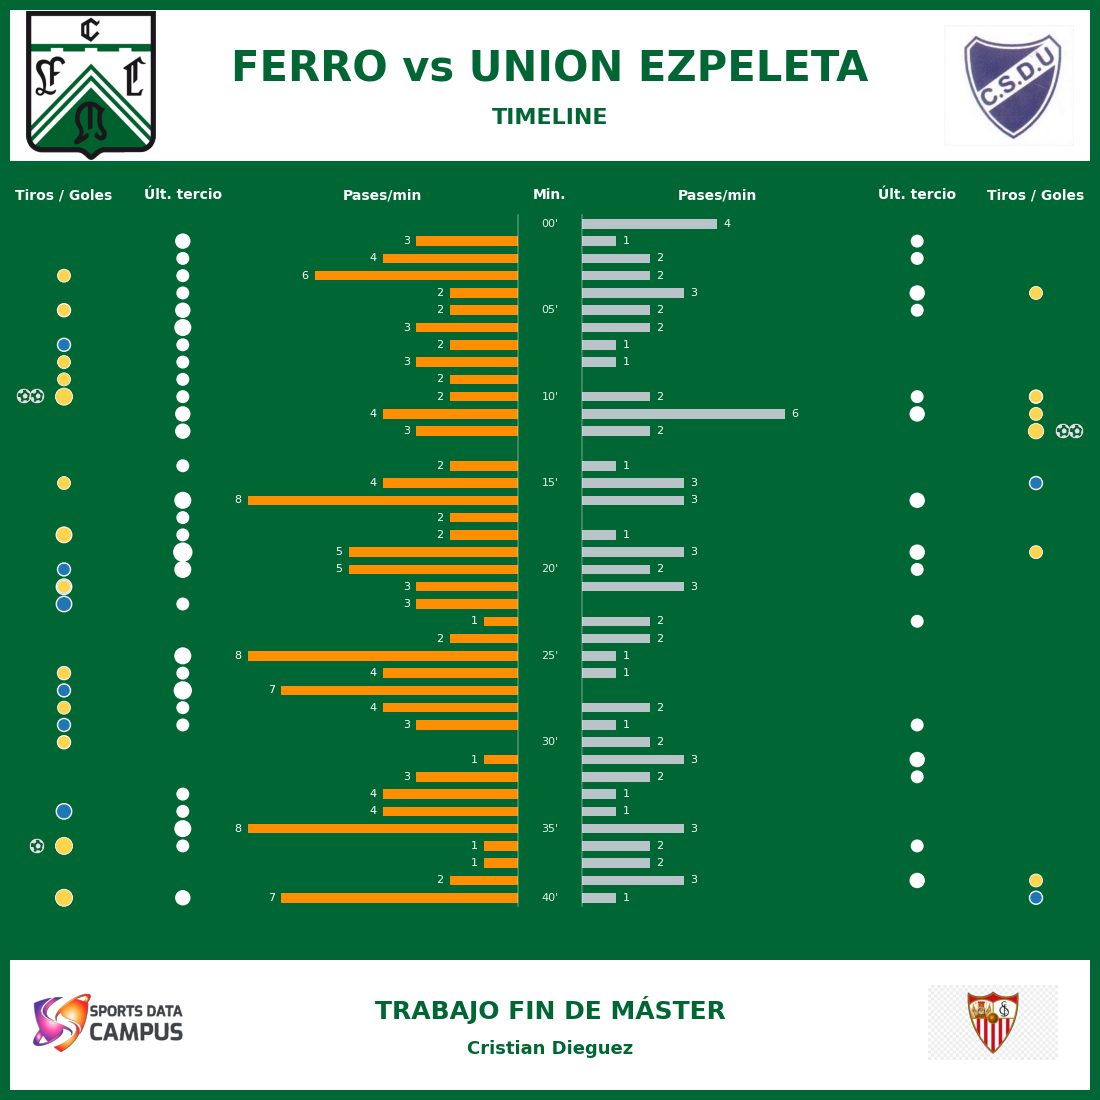

In [78]:
# ================================================
# TIMELINE FUTSAL (0' arriba → 40' abajo)
# Banners + títulos alineados + barras desde el centro
# ================================================

# ---------- RUTAS ----------
XML_EQUIPO    = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Equipo/UnionEzpeletaEq - asXML.xml"
XML_JUGADORES = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Jugadores/Union Ezpeleta - XML NacSport.xml"
MATRIX_PATH   = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Jugadores/Union Ezpeleta - Matrix.xlsx"

LOGO_FERRO_PATH   = "/content/drive/MyDrive/Sport Data Campus/TFM/Equipos/ferro.png"
LOGO_RIVAL_PATH   = "/content/drive/MyDrive/Sport Data Campus/TFM/Equipos/ezpeleta.png"

# Banner inferior (marca personal)
LOGO_LEFT_FOOTER  = "/content/drive/MyDrive/Sport Data Campus/TFM/Banner/SportData.png"
LOGO_RIGHT_FOOTER = "/content/drive/MyDrive/Sport Data Campus/TFM/Banner/Sevilla.png"

# ⚽ PNG de pelota (colocá tu archivo aquí)
BALL_ICON_PATH    = "/content/drive/MyDrive/Sport Data Campus/TFM/Banner/pelota.png"

# ---------- IMPORTS ----------
import os, re, unicodedata, numpy as np, pandas as pd, xml.etree.ElementTree as ET
import matplotlib as mpl, matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle   # ### CAMBIO (Circle)
from PIL import Image
from math import sqrt                              # ### NUEVO

INCLUDE_GOALS_IN_SHOT_CIRCLES = True   # <— ponelo al inicio del script

# ---------- UTILIDADES ----------
def ntext(s):
    if s is None: return ""
    s = str(s)
    s = unicodedata.normalize("NFD", s)
    s = "".join(ch for ch in s if unicodedata.category(ch) != "Mn")
    return s.strip()
def nlower(s): return ntext(s).lower()

def infer_opponent(*paths):
    cand = None
    for p in paths:
        if not p: continue
        base = os.path.basename(p); name = os.path.splitext(base)[0]
        parts = [x.strip() for x in re.split(r"\s*-\s*", name)]
        if parts: cand = parts[0]
        cand = re.sub(r"(?i)categoria\s*\-\s*equipo\s*rival", "", cand or "").strip()
        if cand: break
    cand = re.sub(r"([a-z])([A-Z])", r"\1 \2", cand or "")
    cand = re.sub(r"[_]+", " ", cand).strip()
    return cand if cand else "Rival"

# ---------- PARSE: XML EQUIPO (posesión, opcional) ----------
def parse_possession_from_equipo(xml_path):
    t_ferro = t_rival = 0.0
    root = ET.parse(xml_path).getroot()
    for inst in root.findall(".//instance"):
        code = nlower(inst.findtext("code"))
        try:
            st = float(inst.findtext("start") or "0")
            en = float(inst.findtext("end") or "0")
        except:
            continue
        dur = max(0.0, en - st)
        if code == "tiempo posecion ferro": t_ferro += dur
        elif code == "tiempo posecion rival": t_rival += dur
    tot = t_ferro + t_rival
    if tot <= 0: return 0.0, 0.0
    return round(100*t_ferro/tot,1), round(100*t_rival/tot,1)

# ---------- PARSE: XML JUGADORES (timeline real) ----------
def parse_instances_jugadores(xml_path):
    root = ET.parse(xml_path).getroot()
    out = []
    for inst in root.findall(".//instance"):
        code = ntext(inst.findtext("code"))
        try:
            st = float(inst.findtext("start") or "0"); en = float(inst.findtext("end") or "0")
        except:
            continue
        labels = [nlower(t.text) for t in inst.findall("./label/text")]
        xs = [int(x.text) for x in inst.findall("./pos_x") if (x.text or "").isdigit()]
        ys = [int(y.text) for y in inst.findall("./pos_y") if (y.text or "").isdigit()]
        x_end, y_end = (xs[-1], ys[-1]) if xs and ys else (None, None)
        out.append({"code": code, "labels": labels, "start": st, "end": en, "end_xy": (x_end, y_end)})
    return out

def is_rival_code(code):
    return nlower(code).startswith("categoria - equipo rival")

def is_pass(ev):
    if re.match(r"^\s*pase\b", nlower(ev["code"])): return True
    return any(re.match(r"^\s*pase\b", l) for l in ev["labels"])

def is_shot(ev):
    s = nlower(ev["code"])
    if re.search(r"\btiro\b|\bremate\b", s): return True
    return any(re.search(r"\btiro\b|\bremate\b", l) for l in ev["labels"])

def is_goal(ev):
    s = nlower(ev["code"])
    if re.match(r"^gol\b", s): return True
    return any(re.match(r"^gol\b", l) for l in ev["labels"])

# ### NUEVO: detectar tiro al arco (on target) a partir de labels/código
ON_TARGET_PAT = re.compile(
    r"\b(al\s*arco|a\s*puerta|a\s*porter[ií]a|on\s*target|atajad[oa]|saved\s*shot)\b", re.IGNORECASE
)
def is_shot_on_target(ev):
    s = nlower(ev["code"])
    if ON_TARGET_PAT.search(s): return True
    return any(ON_TARGET_PAT.search(l or "") for l in ev["labels"])

def xy_to_zone(x, y, max_x=19, max_y=34):
    if x is None or y is None: return None
    col = 1 if x <= 6 else (2 if x <= 13 else 3)   # 1..6 | 7..13 | 14..19
    row = 1 if y <= 11 else (2 if y <= 22 else 3)  # 1..11 | 12..22 | 23..34
    return (row-1)*3 + col  # 1..9

def minute_bucket(sec):
    m = int(sec // 60)
    return max(0, min(39, m))  # 0..39

def build_timeline(xml_players_path):
    evs = parse_instances_jugadores(xml_players_path)
    M = 40
    tl = dict(
        passes_M=np.zeros(M, int), passes_R=np.zeros(M, int),
        last_M=np.zeros(M, int),   last_R=np.zeros(M, int),
        # ### CAMBIO: separar tiros on/off target
        shots_on_M=np.zeros(M, int), shots_off_M=np.zeros(M, int),
        shots_on_R=np.zeros(M, int), shots_off_R=np.zeros(M, int),
        goals_M=np.zeros(M, int),  goals_R=np.zeros(M, int),
    )
    for ev in evs:
        m = minute_bucket(ev["end"])   # usar fin del evento

        if is_pass(ev):
            if is_rival_code(ev["code"]): tl["passes_R"][m] += 1
            else:                          tl["passes_M"][m] += 1
            z = xy_to_zone(*ev["end_xy"])
            if z is not None:
                if is_rival_code(ev["code"]):
                    if z in {1,4,7}: tl["last_R"][m] += 1
                else:
                    if z in {3,6,9}: tl["last_M"][m] += 1

        if is_shot(ev):
            goal = is_goal(ev)
            on_t = is_shot_on_target(ev) or goal  # un gol es on target por definición

            if is_rival_code(ev["code"]):
                if goal:
                    tl["goals_R"][m] += 1
                    if INCLUDE_GOALS_IN_SHOT_CIRCLES:
                        tl["shots_on_R"][m] += 1      # <<< suma gol al círculo amarillo
                else:
                    if on_t: tl["shots_on_R"][m]  += 1
                    else:    tl["shots_off_R"][m] += 1
            else:
                if goal:
                    tl["goals_M"][m] += 1
                    if INCLUDE_GOALS_IN_SHOT_CIRCLES:
                        tl["shots_on_M"][m] += 1      # <<< suma gol al círculo amarillo
                else:
                    if on_t: tl["shots_on_M"][m]  += 1
                    else:    tl["shots_off_M"][m] += 1

    return tl

# ---------- THEME ----------
bg_green   = "#006633"
text_w     = "#FFFFFF"
orange_win = "#FF8F00"
rival_g    = "#B9C4C9"
white      = "#FFFFFF"
rail       = "#0F5E29"
yellow_on  = "#FFD54F"   # ### NUEVO: color tiros al arco

mpl.rcParams.update({
    "savefig.facecolor": bg_green,
    "figure.facecolor":  bg_green,
    "axes.facecolor":    bg_green,
    "text.color":        text_w,
    "font.size":         11,
})

# ---------- IMG HELPERS ----------
def load_rgba(path):
    im = Image.open(path); im.load()
    if im.mode != "RGBA": im = im.convert("RGBA")
    return np.array(im)

def draw_logo(ax, path, cx, cy, w=0.11, trim=True):
    try:
        img = load_rgba(path)
        if trim:
            a = img[:,:,3]
            rgb = img[:,:,:3]
            white_mask = (np.abs(255 - rgb).max(axis=2) <= 10)
            useful = (~white_mask) | (a > 0)
            rows = np.where(useful.any(axis=1))[0]
            cols = np.where(useful.any(axis=0))[0]
            if rows.size and cols.size:
                img = img[rows[0]:rows[-1]+1, cols[0]:cols[-1]+1, :]
    except Exception:
        return
    h, wpx = img.shape[0], img.shape[1]
    asp = h / wpx if wpx else 1.0
    ax.imshow(img, extent=[cx - w/2, cx + w/2, cy - w*asp/2, cy + w*asp/2], zorder=10)

# --- Pelota PNG (pequeño helper) ---
def try_load_ball():
    try:
        return load_rgba(BALL_ICON_PATH)
    except Exception:
        return None

BALL_IMG = try_load_ball()

def draw_ball(ax, x_center, y_center, size=0.018):
    if BALL_IMG is None:
        ax.text(x_center, y_center, "⚽", ha="center", va="center", fontsize=8)
        return
    h, wpx = BALL_IMG.shape[0], BALL_IMG.shape[1]
    asp = h / wpx if wpx else 1.0
    ax.imshow(
        BALL_IMG,
        extent=[x_center - size/2, x_center + size/2,
                y_center - (size*asp)/2, y_center + (size*asp)/2],
        zorder=9
    )

# ---------- DATOS ----------
opponent_name = infer_opponent(XML_JUGADORES, XML_EQUIPO, MATRIX_PATH)
pos_m, pos_r  = parse_possession_from_equipo(XML_EQUIPO)
tl            = build_timeline(XML_JUGADORES)

# ---------- FIGURA ----------
plt.close("all")
fig_h = 11.8
fig = plt.figure(figsize=(10.8, fig_h))
ax  = fig.add_axes([0,0,1,1])
ax.set_xlim(0,1); ax.set_ylim(0,1); ax.axis("off")
ax.add_patch(Rectangle((0,0), 1, 1, facecolor=bg_green, edgecolor="none"))

# ----- Banner superior -----
BANNER_H = 0.14; BANNER_Y0 = 1 - BANNER_H
ax.add_patch(Rectangle((0, BANNER_Y0), 1, BANNER_H, facecolor=white, edgecolor="none"))
draw_logo(ax, LOGO_FERRO_PATH, 0.075, BANNER_Y0+0.07, w=0.12)
draw_logo(ax, LOGO_RIVAL_PATH, 0.925, BANNER_Y0+0.07, w=0.12)
ax.text(0.5, BANNER_Y0+0.085, f"FERRO vs {opponent_name.upper()}", ha="center", va="center",
        color=bg_green, fontsize=30, weight="bold")
ax.text(0.5, BANNER_Y0+0.040, "TIMELINE", ha="center", va="center",
        color=bg_green, fontsize=16, weight="bold")

# ----- Banner inferior -----
FOOT_H, FOOT_Y0 = 0.12, 0.00
ax.add_patch(Rectangle((0, FOOT_Y0), 1, FOOT_H, facecolor=white, edgecolor="none"))
draw_logo(ax, LOGO_LEFT_FOOTER, 0.09, FOOT_Y0+FOOT_H*0.52, w=0.14)
draw_logo(ax, LOGO_RIGHT_FOOTER, 0.91, FOOT_Y0+FOOT_H*0.52, w=0.12)
ax.text(0.50, FOOT_Y0+FOOT_H*0.62, "TRABAJO FIN DE MÁSTER", ha="center", va="center",
        color=bg_green, fontsize=18, weight="bold")
ax.text(0.50, FOOT_Y0+FOOT_H*0.32, "Cristian Dieguez", ha="center", va="center",
        color=bg_green, fontsize=13, weight="bold")

# ----- Panel central -----
panel_y0, panel_y1 = FOOT_Y0+FOOT_H+0.05, BANNER_Y0-0.05
panel_h = panel_y1 - panel_y0

# Columnas (alineamos títulos encima del panel)
x_center_gap_L = 0.47
x_center_gap_R = 0.53

# Barras desde el centro hacia afuera
x_bar_M_max = 0.22
x_bar_R_max = 0.78

# Columnas de tiros/goles y último tercio
x_shot_M  = 0.05
x_last_M  = 0.16
x_shot_R  = 0.95
x_last_R  = 0.84
# NUEVO: goles “hacia afuera” (más afuera que tiros)
x_goal_M  = x_shot_M - 0.025   # más a la izquierda que los tiros
x_goal_R  = x_shot_R + 0.025   # más a la derecha que los tiros

# Títulos
ty = panel_y1 + 0.012
ax.text(x_last_M,  ty, "Últ. tercio", ha="center", va="bottom", fontsize=10, weight="bold")
ax.text((x_bar_M_max+x_center_gap_L)/2, ty, "Pases/min", ha="center", va="bottom", fontsize=10, weight="bold")
ax.text(x_shot_M,  ty, "Tiros / Goles", ha="center", va="bottom", fontsize=10, weight="bold")
ax.text((x_center_gap_L+x_center_gap_R)/2, ty, "Min.", ha="center", va="bottom", fontsize=10, weight="bold")
ax.text((x_center_gap_R+x_bar_R_max)/2, ty, "Pases/min", ha="center", va="bottom", fontsize=10, weight="bold")
ax.text(x_shot_R,  ty, "Tiros / Goles", ha="center", va="bottom", fontsize=10, weight="bold")
ax.text(x_last_R,  ty, "Últ. tercio", ha="center", va="bottom", fontsize=10, weight="bold")

# Minutos: 0' arriba → 40' abajo
M = 40
def y_of_index(i):
    return panel_y1 - panel_h * (i + 0.5) / M

# eje central
ax.add_line(plt.Line2D([x_center_gap_L, x_center_gap_L], [panel_y0, panel_y1], color=white, alpha=0.28, lw=1.2))
ax.add_line(plt.Line2D([x_center_gap_R, x_center_gap_R], [panel_y0, panel_y1], color=white, alpha=0.28, lw=1.2))

# etiquetas 0,5,10,...,40
for m in range(0, 41, 5):
    yy = y_of_index(min(m, 39))
    ax.text(0.50, yy, f"{m:02d}'", ha="center", va="center", fontsize=8, alpha=0.90)

# Escalas de barras
max_bar = max(tl["passes_M"].max() if tl["passes_M"].size else 1,
              tl["passes_R"].max() if tl["passes_R"].size else 1, 1)

def bar_width_left(cnt):
    total_span = (x_center_gap_L - x_bar_M_max)
    return total_span * (cnt / max_bar if max_bar else 0)

def bar_width_right(cnt):
    total_span = (x_bar_R_max - x_center_gap_R)
    return total_span * (cnt / max_bar if max_bar else 0)

# ### NUEVO: helpers de círculos (tamaño proporcional a cantidad)
def draw_count_circle(ax, x, y, count, base_r=0.006, face=None, edge=white, lw=1.0, z=8):
    """Un solo círculo con radio ~ sqrt(count). Si count=0, no dibuja."""
    if count <= 0: return
    r = base_r * sqrt(count ** 0.5)  # área ~ cantidad
    circ = Circle((x, y), radius=r, facecolor=face, edgecolor=edge, linewidth=lw, zorder=z)
    ax.add_patch(circ)

# DIBUJO POR MINUTO
bar_h = panel_h / M * 0.55
for m in range(M):
    y = y_of_index(m)

    # --- FERRO (izquierda) ---
    wL = bar_width_left(tl["passes_M"][m])
    x0L = x_center_gap_L - wL
    ax.add_patch(Rectangle((x0L, y - bar_h/2), wL, bar_h, facecolor=orange_win, edgecolor="none"))
    if tl["passes_M"][m] > 0:
        ax.text(x0L - 0.006, y, f"{tl['passes_M'][m]}", ha="right", va="center", fontsize=8)

    # Último tercio FERRO (●) → círculo único acumulado
    draw_count_circle(ax, x_last_M, y, tl["last_M"][m], base_r=0.006, face=white, edge=white, lw=0.0, z=7)

    # Tiros FERRO:
    # - off target: círculo hueco (sin relleno)
    draw_count_circle(ax, x_shot_M, y, tl["shots_off_M"][m], base_r=0.006, face=None, edge=white, lw=1.0, z=8)
    # - on target (no gol): círculo amarillo
    draw_count_circle(ax, x_shot_M, y, tl["shots_on_M"][m],  base_r=0.006, face=yellow_on, edge=white, lw=0.6, z=9)
    # - goles: pelota PNG (mantiene tu estilo original)
    if tl["goals_M"][m] > 0:
        for k in range(int(tl["goals_M"][m])):
            draw_ball(ax, x_goal_M - k*0.012, y, size=0.016)  # hacia afuera

    # --- RIVAL (derecha) ---
    wR = bar_width_right(tl["passes_R"][m])
    x0R = x_center_gap_R
    ax.add_patch(Rectangle((x0R, y - bar_h/2), wR, bar_h, facecolor=rival_g, edgecolor="none"))
    if tl["passes_R"][m] > 0:
        ax.text(x0R + wR + 0.006, y, f"{tl['passes_R'][m]}", ha="left", va="center", fontsize=8)

    # Último tercio RIVAL (●) → círculo único acumulado
    draw_count_circle(ax, x_last_R, y, tl["last_R"][m], base_r=0.006, face=white, edge=white, lw=0.0, z=7)

    # Tiros RIVAL:
    draw_count_circle(ax, x_shot_R, y, tl["shots_off_R"][m], base_r=0.006, face=None, edge=white, lw=1.0, z=8)
    draw_count_circle(ax, x_shot_R, y, tl["shots_on_R"][m],  base_r=0.006, face=yellow_on, edge=white, lw=0.6, z=9)
    if tl["goals_R"][m] > 0:
        for k in range(int(tl["goals_R"][m])):
            draw_ball(ax, x_goal_R + k*0.012, y, size=0.016)  # hacia afuera

# (Opcional) Posesión
# ax.text(0.5, BANNER_Y0-0.006, f"Posesión: FERRO {pos_m:.1f}%  |  {opponent_name.upper()} {pos_r:.1f}%",
#         ha="center", va="top", fontsize=10, alpha=0.9)

# ---------- EXPORT ----------
out_path = "/content/timeline_center_out_ferro_vs_{}.png".format(opponent_name.replace(" ","_"))
plt.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches=0.04)
plt.show()
# print("✅ Exportado:", out_path)
